In [6]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# The problem the data

We are given the following data

- Top 25 Reddit news title for each day along with DJIAI
- Train data: Reddit news titles from 2008-08-08 to 2015-06-30 and DJIAI from 2008-08-08 to 2015-07-01. Note that there is one day difference between Reddit news titles and DJIAI
- Test data: Reddit news titles from 2015-07-01 to 2016-06-30
- The task is to predict weather DJIAI goes up or down next day(binary classification) from 2015-07-01 to 2016-06-30 with neural network.

In [7]:
train = pd.read_csv('dataset/train.csv')
train['timestamp'] = pd.to_datetime(train['timestamp'])
test = pd.read_csv('dataset/test.csv')
test['timestamp'] = pd.to_datetime(test['timestamp'])

In [8]:
train.head()

,timestamp,News,Price
0,2015-07-01,NaN,17757.910156
1,2015-06-30,['US now has more Spanish speakers than Spain ...,17619.509766
2,2015-06-29,"[""'Blind agreement' and closed-door deals: Rep...",17596.349609
3,2015-06-26,['Man beheaded and Islamist flag raised in Gre...,17946.679688
4,2015-06-25,['South Korea says it will send aid to North K...,17890.359375


In [9]:
test.head()

,timestamp,News
0,2016-06-30,['Jamaica proposes marijuana dispensers for to...
1,2016-06-29,"['Explosion At Airport In Istanbul', 'Yemeni f..."
2,2016-06-28,"['2,500 Scientists To Australia: If You Want T..."
3,2016-06-27,['Barclays and RBS shares suspended from tradi...
4,2016-06-24,['David Cameron to Resign as PM After EU Refer...


- We can see that while the train has the price data the testing does not. Hence we will give predictions but will not be able to validate our model. when testing perhaps we break train into train and CV.
- We also can see that there is one missing News article let's just confirm that that is the only missing value

In [10]:
train.isnull().sum().sort_values(ascending=False)

News         1
Price        0
timestamp    0
dtype: int64

In [11]:
test.isnull().sum().sort_values(ascending=False)

News         0
timestamp    0
dtype: int64

- Only one new article row is missing from the train as mentioned in the initial blurb. This makes sense so we can create the targets using the previous data for the DJIAI

In [12]:
print 'training rows: %d' % train.shape[0]
print 'test rows: %d' % test.shape[0]

training rows: 1736
test rows: 253


In [13]:
train.dtypes

timestamp    datetime64[ns]
News                 object
Price               float64
dtype: object

In [14]:
test.dtypes

timestamp    datetime64[ns]
News                 object
dtype: object

- Let's take a look at what one of the article posts looks like

In [15]:
train['News'][1]

'[\'US now has more Spanish speakers than Spain  only Mexico has more\', \'At least 116 feared dead in after Indonesian military plane crashes into a major city\', \'ISIS just executed its top official in Mosul for planning a coup\', \'The remains of an unidentified sea animal with fur on its tail have been washed ashore in the Far East. Found near the airport at Shakhtersk, on Sakhalin Island, its appearance is unlike anything ever found in Russia.\', \'1,000 runners get norovirus after French mud run\', \'Saudi comedian gets death threats for satirizing IS\', "ISIS executes women by beheading for the first time for \'sorcery\' in Syria", \'South Sudan army raped and then burned girls alive, says UN\', \'Australia bans 220 videogames in four months as Government adopts new classification model\', \'New WikiLeaks Documents Reveal NSA Spied On Top French Companies\', \'Russia to review 1991 decision to recognise independence of Baltic states\', \'CIA photos of black sites could complica

- Looks like in news column it incudes all the 25 top articles in one column for that specific date.
- 2 Ways to deal with this:
    1. Clean this up and create BOW, TFIDF, or W2V average for the multiple titles. 
    2. Or break each 25 articles into different rows
- To clean the text we will concatenate both train and test together.

In [16]:
train['Price'].describe()

count     1736.000000
mean     12910.766845
std       2977.616138
min       6547.049805
25%      10605.932862
50%      12576.375000
75%      15520.934815
max      18312.390625
Name: Price, dtype: float64

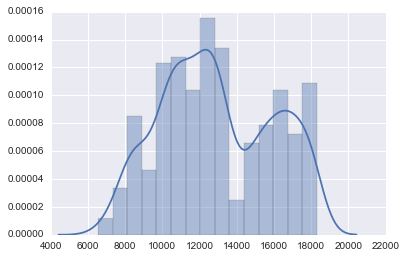

In [17]:
sns.distplot(train.Price.values, kde=True)
plt.show()

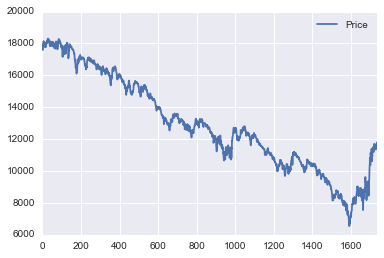

In [18]:
train.plot()

# Create targets

- Create a 1 if the price is the same or larger as previous price
- Put a 0 if the price is less than the previous price
- It was told to us that the dates are off put one day so that the targets are truely predicting the next day.
- Something to think about is off setting two days as the market may not adjust so quickly.

In [19]:
train.sort_values('timestamp', inplace = True) # sort data so that the targets make sense
targets = []
targets.append(np.nan)
for idx in range(1,train.shape[0]):
    prev_price = train.iloc[idx-1].loc['Price']
    curr_price = train.iloc[idx].loc['Price']
    if curr_price >= prev_price:
        curr_targ = 1
    else:
        curr_targ = 0
    targets.append(curr_targ)
train['targets'] = targets

In [20]:
train.head() # double check targets that they make sense

,timestamp,News,Price,targets
1735,2008-08-08,"['b""Georgia \'downs two Russian warplanes\' as...",11734.320312,NaN
1734,2008-08-11,"[""b'Why wont America and Nato help us? If they...",11782.349609,1.0
1733,2008-08-12,"[""b'Remember that adorable 9-year-old who sang...",11642.469727,0.0
1732,2008-08-13,"[""b' U.S. refuses Israel weapons to attack Ira...",11532.959961,0.0
1731,2008-08-14,"[""b'All the experts admit that we should legal...",11615.929688,1.0


In [21]:
train['News'].fillna('EMPTY', inplace=True)

In [22]:
print 'Count of targets = 1: %d' % (train[train['targets'] == 1]['targets']).count()
print 'Count of targets = 0: %d' % (train[train['targets'] == 0]['targets']).count()

Count of targets = 1: 937
Count of targets = 0: 798


- The counts are some what even but we should still look at an F1 measure since they are not perfectly distributed. 

# Clean up Text

In [23]:
import nltk
from nltk.tokenize import word_tokenize
import HTMLParser
from bs4 import BeautifulSoup
from markdown import markdown
import urllib2
from nltk.stem import PorterStemmer
from nltk import word_tokenize 
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from nltk.stem.wordnet import WordNetLemmatizer
import re
from markdown import markdown
from nltk.corpus import stopwords # Import the stop word list

lmtzr = WordNetLemmatizer()
class WordNetLemmatizer(object):
    def __init__(self):
        self.lmtzr = lmtzr.lemmatize    
    def __call__(self, doc):
        return [self.lmtzr(t) for t in word_tokenize(doc)]

In [24]:
tfidfvect = TfidfVectorizer(
    ngram_range=(2,2),
    encoding = 'utf-8',
    tokenizer = WordNetLemmatizer(),
    # tokenizer = PorterTokenizer(),
    stop_words = stopwords.words('english'),
    lowercase = True
)

countvect = CountVectorizer(
    ngram_range=(2,2),
    encoding = 'utf-8',
    tokenizer = WordNetLemmatizer(),
    # tokenizer = PorterTokenizer(),
    stop_words = stopwords.words('english'),
    lowercase = True
)

- Create a function for one off weird words that I can fix here.

In [25]:
def clean_text(example):
    example1 = example.replace("\\\'", "")
    example2 = example1.replace('"b','')
    example3 = example2.replace("'b","")
    example4 = example3.replace('U.S.', 'US')
    example5 = example4.replace('U.N.', 'UN')
    example6 = example5.replace('U.K.', 'UK')
    example7 = example6.replace('al queda', 'alqueda')
    return example7

In [26]:
def structure_text(example, featuretype, remove_stopwords=True):
    example1 = clean_text(example)
    example2 = BeautifulSoup(example1,'lxml')
    example3 = re.sub("[^a-zA-Z]", " ", example2.get_text())
    example4 = example3.lower() 
    example5 = example4.split()
    if remove_stopwords:
        stops = set(stopwords.words("english"))
        words = [w for w in example5 if not w in stops]  
        
    if featuretype == 'tfidf' or featuretype == 'count' or featuretype == 'word2vec':
        return( " ".join( words )) 
    else: 
        return words

In [27]:
def cleanwords(train, test, featuretype):
    clean_train_reviews_raw = []
    clean_test_reviews_raw = []
    for i in range(train.shape[0]):
        clean_train_reviews_raw.append( structure_text( train['News'].iloc[i], featuretype ) )
    for i in range(test.shape[0]):
        clean_test_reviews_raw.append( structure_text( test['News'].iloc[i], featuretype ) )
    return clean_train_reviews_raw, clean_test_reviews_raw

In [28]:
train['News'][1]

'[\'US now has more Spanish speakers than Spain  only Mexico has more\', \'At least 116 feared dead in after Indonesian military plane crashes into a major city\', \'ISIS just executed its top official in Mosul for planning a coup\', \'The remains of an unidentified sea animal with fur on its tail have been washed ashore in the Far East. Found near the airport at Shakhtersk, on Sakhalin Island, its appearance is unlike anything ever found in Russia.\', \'1,000 runners get norovirus after French mud run\', \'Saudi comedian gets death threats for satirizing IS\', "ISIS executes women by beheading for the first time for \'sorcery\' in Syria", \'South Sudan army raped and then burned girls alive, says UN\', \'Australia bans 220 videogames in four months as Government adopts new classification model\', \'New WikiLeaks Documents Reveal NSA Spied On Top French Companies\', \'Russia to review 1991 decision to recognise independence of Baltic states\', \'CIA photos of black sites could complica

In [29]:
clean_train_reviews_raw, clean_test_reviews_raw = cleanwords(train, test, 'tfidf')

- Look pretty good.
- Some words are weirdly broken up al queda, however there will be alot of one offs that we can add to out list as wel go through.

# Create Features

Lets test out three different types of features:
- Bag of Words
- TFIDF
- Word to Vec - For Word to Vec since our data is relatively small we may try to find pretrained word vector.

In [30]:
def makeFeatureVec(words, model, num_features):
    featureVec = np.zeros((num_features,),dtype="float32")
    nwords = 0.
    index2word_set = set(model.index2word)
    for word in words:
        if word in index2word_set: 
            nwords = nwords + 1.
            featureVec = np.add(featureVec,model[word])
    featureVec = np.divide(featureVec,nwords)
    return featureVec


def getAvgFeatureVecs(reviews, model, num_features):
    counter = 0
    reviewFeatureVecs = np.zeros((len(reviews),num_features),dtype="float32")
    for review in reviews:
        print "Review %d of %d" % (counter, len(reviews))
        #print 'review', review
        reviewFeatureVecs[counter] = makeFeatureVec(review, model, num_features)
        counter = counter + 1
    return reviewFeatureVecs

In [31]:
clean_train_reviews_raw

[u'georgia downs two russian warplanes countries move brink war breaking musharraf impeached russia today columns troops roll south ossetia footage fighting youtube russian tanks moving towards capital south ossetia reportedly completely destroyed georgian artillery fire afghan children raped impunity un official says sick three year old raped nothing russian tanks entered south ossetia whilst georgia shoots two russian jets breaking georgia invades south ossetia russia warned would intervene sos side enemy combatent trials nothing sham salim haman sentenced years kept longer anyway feel like georgian troops retreat osettain capital presumably leaving several hundred people killed video us prep georgia war russia rice gives green light israel attack iran says us veto israeli military ops announcing class action lawsuit behalf american public fbi russia georgia war nyts top story opening ceremonies olympics fucking disgrace yet proof decline journalism china tells bush stay countries af

In [32]:
def convertfeatures(train, test, featuretype, model=None, num_features=None):
    if featuretype == 'tfidf':
        train_data_features = tfidfvect.fit_transform(train)
        train_data_features = train_data_features.toarray()
        test_data_features = tfidfvect.transform(test)
        test_data_features = test_data_features.toarray()        
    elif featuretype == 'count':
        train_data_features = countvect.fit_transform(train)
        train_data_features = train_data_features.toarray()
        test_data_features = countvect.fit_transform(test)
        test_data_features = test_data_features.toarray()
    elif featuretype == 'word2vec':
        train_data_features = getAvgFeatureVecs( train, model, num_features )
        test_data_features = getAvgFeatureVecs( test, model, num_features )
    return train_data_features, test_data_features

In [33]:
#train_data_features, test_data_features = convertfeatures(clean_train_reviews_raw, clean_test_reviews_raw, 'count')
train_data_features, test_data_features = convertfeatures(clean_train_reviews_raw, clean_test_reviews_raw, 'tfidf')

In [34]:
train_data_features

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

In [35]:
print 'clean reviews train: %d' % len(clean_train_reviews_raw)
print 'clean review test: %d' % len(clean_test_reviews_raw)

clean reviews train: 1736
clean review test: 253


In [36]:
train_data_features.shape

(1736, 371131)

# test base line model for score and feature importances using 2-gram tfidf

In [37]:
from sklearn.ensemble import RandomForestClassifier
forest = RandomForestClassifier(n_estimators = 100) 

train_data_features2 = train_data_features[1:,]
train_target2 = train['targets'][1:]

forest.fit( train_data_features2, train_target2)

print 'train score %f' % forest.score(train_data_features2, train_target2)

train score 1.000000


- the score is perfect. However It is very possible that it has over fit.
- Let's make sure the features look some what right and then retrain breaking the train into TRAIN, CV

In [38]:
for_values, for_names = zip(*sorted(zip(forest.feature_importances_, tfidfvect.get_feature_names())))
for_features = pd.DataFrame({'feature_importance' : for_values, 'feature_name' : for_names})
for_features.sort_values('feature_importance', ascending=False).head(25)

,feature_importance,feature_name
371130,0.001229,hacking scandal
371129,0.001133,nuclear weapon
371128,0.001124,n bbc
371127,0.000981,west africa
371126,0.000967,iran nuclear
371125,0.000896,greenhouse gas
371124,0.000889,christopher hitchens
371123,0.000843,ordered pay
371122,0.000839,nuclear plant
371121,0.000822,child porn


In [39]:
def createtraintestsplit(train, train_data_features):
    train_sample = train[train['timestamp'] <= pd.to_datetime('2014-06-30')]
    cv_sample = train[(train['timestamp'] >= pd.to_datetime('2014-07-01')) & (train['timestamp'] <= pd.to_datetime('2015-06-30'))]
    
    y_train = train_sample['targets'][1:]
    y_cv = cv_sample['targets']
    
    X_train = train_data_features[1:1483,:]
    X_cv = train_data_features[1484:,:]
    return X_train, y_train, X_cv, y_cv 

In [40]:
X_train, y_train, X_cv, y_cv  = createtraintestsplit(train, train_data_features)

In [41]:
forest2 = RandomForestClassifier(n_estimators = 100) 
forest2.fit( X_train, y_train)

print 'train score %f' % forest2.score(X_train, y_train)
print 'cv score %f' % forest2.score(X_cv, y_cv)

train score 1.000000
cv score 0.527778


- now we can see that it seems to be way overfitting.
- A couple ways to alleviate it could be less features so its not over fitting to this.
- Let's try changing the dimenion of vector to 2000

In [42]:
tfidfvect = TfidfVectorizer(
    ngram_range=(2,2),
    encoding = 'utf-8',
    tokenizer = WordNetLemmatizer(),
    # tokenizer = PorterTokenizer(),
    stop_words = stopwords.words('english'),
    lowercase = True,
    max_features = 300000
)

In [43]:
train_data_features2, test_data_features2 = convertfeatures(clean_train_reviews_raw, clean_test_reviews_raw, 'tfidf')
X_train2, y_train2, X_cv2, y_cv2  = createtraintestsplit(train, train_data_features2)

In [44]:
forest3 = RandomForestClassifier(n_estimators = 100) 
forest3.fit( X_train2, y_train2)

print 'train score %f' % forest3.score(X_train2, y_train2)
print 'cv score %f' % forest3.score(X_cv2, y_cv2)

train score 1.000000
cv score 0.527778


- that score is worse so i guess extra features were better. I think also trying a neural network could help and it does better with more features

# NEURAL NETWORKS

In [48]:
import numpy as np
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Lambda
from keras.layers.embeddings import Embedding
from keras.layers.recurrent import LSTM, SimpleRNN, GRU

from keras.layers import Convolution2D, MaxPooling2D
from keras.utils import np_utils
from collections import defaultdict
from keras import backend as K
K.set_image_dim_ordering('th')
from keras.layers.convolutional import Convolution1D

## LSTM

In [49]:
nb_classes = 2
max_features = 7700
EMBEDDING_DIM = 200
VALIDATION_SPLIT = 0.1
maxlen = 200
batch_size = 32

In [50]:
# structure inputs for hte model
clean_review_TRAIN = clean_train_reviews_raw[1:1483]
clean_review_CV = clean_train_reviews_raw[1484:]

# vectorize the text samples into a 2D integer tensor
tokenizer = Tokenizer(num_words=max_features)

tokenizer.fit_on_texts(clean_review_TRAIN)
sequences_train = tokenizer.texts_to_sequences(clean_review_TRAIN)
sequences_test = tokenizer.texts_to_sequences(clean_review_CV)

print('Pad sequences (samples x time)')
X_train = sequence.pad_sequences(sequences_train, maxlen=maxlen)
X_test = sequence.pad_sequences(sequences_test, maxlen=maxlen)

Y_train = np_utils.to_categorical(y_train2, nb_classes)
Y_test = np_utils.to_categorical(y_cv2, nb_classes)


print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)

Pad sequences (samples x time)
('X_train shape:', (1482, 200))
('X_test shape:', (252, 200))


In [51]:
def LSTMmodel(max_features = 10000, nb_classes = 2):
    model = Sequential()
    model.add(Embedding(max_features, 128))
    model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2)) 
    model.add(Dense(nb_classes))
    model.add(Activation('softmax'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

model = LSTMmodel(max_features = 10000, nb_classes = 2)

print('Train...')
model.fit(X_train, Y_train, batch_size=batch_size, nb_epoch=3,
          validation_data=(X_test, Y_test))
score_train, acc_train = model.evaluate(X_train, Y_train,
                            batch_size=batch_size)

score, acc = model.evaluate(X_test, Y_test,
                            batch_size=batch_size)

print('Train score:', score_train)
print('Train accuracy:', acc_train)
print('Test score:', score)
print('Test accuracy:', acc)

Train...


/Users/laurenmccarthy/anaconda2/lib/python2.7/site-packages/Keras-2.0.8-py2.7.egg/keras/models.py:852: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 1482 samples, validate on 252 samples
Epoch 1/3
1482/1482 [==============================] - 39s - loss: 0.6917 - acc: 0.5371 - val_loss: 0.6931 - val_acc: 0.5278
Epoch 2/3
1482/1482 [==============================] - 37s - loss: 0.6490 - acc: 0.6923 - val_loss: 0.7169 - val_acc: 0.4960
Epoch 3/3
252/252 [==============================] - 1s     
('Train score:', 0.12358568944589973)
('Train accuracy:', 0.9811066126855601)
('Test score:', 0.91953312404572018)
('Test accuracy:', 0.52380952191731289)


In [52]:
print("Generating test predictions...")
preds15 = model.predict_classes(X_train, verbose=0)
print('Predictions', preds15)

Generating test predictions...
('Predictions', array([1, 0, 0, ..., 0, 1, 0]))


- While this has imporved to a 55% accuracy, we can most likely still do better.

# Word2Vec - with google pretrained word vector

In [53]:
import gensim
from gensim.models.keyedvectors import KeyedVectors
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Activation
from keras.layers.embeddings import Embedding
from keras.layers import Convolution1D, MaxPooling1D
import numpy as np
from keras.utils import np_utils

In [54]:
# structure inputs for the model
train = train.dropna()
clean_train_reviews_raw, clean_test_reviews_raw = cleanwords(train, test, 'word2vec')

In [55]:
google_embeddings = 'dataset/GoogleNews-vectors-negative300.bin'
MAX_SEQUENCE_LENGTH = 50
MAX_NB_WORDS = 200000
EMBEDDING_DIM = 300
maxlen = 200
nb_classes = 2
max_features = 2000

In [56]:
word2vec = KeyedVectors.load_word2vec_format(google_embeddings, binary=True)

- test the model. Just to confirm that the word vector is good.

In [57]:
word2vec.most_similar(positive=['woman', 'king'], negative=['man'])

[(u'queen', 0.7118192315101624),
 (u'monarch', 0.6189674139022827),
 (u'princess', 0.5902431011199951),
 (u'crown_prince', 0.5499460697174072),
 (u'prince', 0.5377321839332581),
 (u'kings', 0.5236844420433044),
 (u'Queen_Consort', 0.5235946178436279),
 (u'queens', 0.5181134343147278),
 (u'sultan', 0.5098593235015869),
 (u'monarchy', 0.5087412595748901)]

In [58]:
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(clean_train_reviews_raw)

sequences_train = tokenizer.texts_to_sequences(clean_train_reviews_raw)
sequences_test = tokenizer.texts_to_sequences(clean_test_reviews_raw)

X_train = sequence.pad_sequences(sequences_train, maxlen=maxlen)
X_test = sequence.pad_sequences(sequences_test, maxlen=maxlen)

Y_train = np_utils.to_categorical(train['targets'], nb_classes)

word_index = tokenizer.word_index

nb_words = min(MAX_NB_WORDS, len(word_index))+1

In [59]:
embedding_matrix = np.zeros((nb_words, EMBEDDING_DIM))

notinwordlist = []
for word, i in word_index.items():
    if word in word2vec.vocab:
        embedding_matrix[i] = word2vec.word_vec(word)
    else:
        notinwordlist.append(word)
print('Null word embeddings: %d' % np.sum(np.sum(embedding_matrix, axis=1) == 0))
print('Not Null word embeddings: %d' % np.sum(np.sum(embedding_matrix, axis=1) != 0))


Null word embeddings: 6858
Not Null word embeddings: 25206


In [60]:
# take a look at words that did not appear - think of a way to include these - by processing
notinwordlist

[u'herve',
 u'islamizing',
 u'overissuance',
 u'hedegaard',
 u'eltahawy',
 u'lamido',
 u'intruduced',
 u'bbqs',
 u'francesco',
 u'qashoushs',
 u'saddams',
 u'kibungo',
 u'nawi',
 u'pistorious',
 u'toowoomba',
 u'tomasevic',
 u'wikimedia',
 u'dnd',
 u'nromania',
 u'fazlullah',
 u'trashslide',
 u'gershon',
 u'radicalisation',
 u'barbra',
 u'ghadafi',
 u'sohag',
 u'hetherington',
 u'nfascinating',
 u'salients',
 u'mcgarahan',
 u'shinawatra',
 u'nlong',
 u'jamali',
 u'elieves',
 u'liberalised',
 u'neonazis',
 u'phoenicians',
 u'veracruz',
 u'vologda',
 u'mairead',
 u'ombs',
 u'nsweden',
 u'driru',
 u'jannati',
 u'antilles',
 u'nministers',
 u'saeed',
 u'africaincluding',
 u'tawergha',
 u'supervoid',
 u'ntaxpayers',
 u'pitful',
 u'ncountry',
 u'violeted',
 u'islamabads',
 u'guizhou',
 u'finkelsteins',
 u'jabari',
 u'marshburn',
 u'himalayas',
 u'khandan',
 u'nsome',
 u'libyas',
 u'majid',
 u'statesmans',
 u'khomenei',
 u'nradiation',
 u'hatla',
 u'adenhart',
 u'tiscali',
 u'mcnamara',
 u'ba

In [61]:
n_symbols = len(embedding_matrix)
vocab_dim = len(embedding_matrix[0])
nb_epoch=3
batch_size=64

In [62]:
def createtraintestsplit(X_train, y_train):
    X_train_val = X_train[:1483,:]
    X_cv_val = X_train[1483:,:]
    
    y_train_val = y_train[:1483,:]
    y_cv_val = y_train[1483:,:]
    return X_train_val, X_cv_val, y_train_val, y_cv_val

In [63]:
X_train_val, X_cv_val, y_train_val, y_cv_val = createtraintestsplit(X_train, Y_train)

In [64]:
model = Sequential()
model.add(Embedding(output_dim=vocab_dim, input_dim=n_symbols, weights=[embedding_matrix]))  # note you have to put embedding weights in a list by convention
model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2)) 
model.add(Dense(nb_classes))
model.add(Activation('softmax'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.fit(X_train_val, y_train_val, validation_data=(X_cv_val, y_cv_val), nb_epoch=nb_epoch, batch_size=batch_size)

Train on 1483 samples, validate on 252 samples
Epoch 1/3
1483/1483 [==============================] - 41s - loss: 0.6942 - acc: 0.5233 - val_loss: 0.6974 - val_acc: 0.5198
Epoch 2/3
1483/1483 [==============================] - 38s - loss: 0.6344 - acc: 0.6851 - val_loss: 0.7244 - val_acc: 0.5397
Epoch 3/3
1483/1483 [==============================] - 37s - loss: 0.4289 - acc: 0.8227 - val_loss: 0.8505 - val_acc: 0.5556


In [66]:
score_train, acc_train = model.evaluate(X_train_val, y_train_val,
                            batch_size=batch_size)

score_cv, acc_cv = model.evaluate(X_cv_val, y_cv_val,
                            batch_size=batch_size)

print('Train accuracy:', acc_train)
print('CV accuracy:', acc_cv)

252/252 [==============================] - 1s     
('Train accuracy:', 0.96898179366149695)
('CV accuracy:', 0.55555555366334464)


# Things to think about:

1. Since the news is happening the same day of the stock there may be some lag - think about changing the date of prediction
2. Could break up the titles to different rows, perform sentiment analysis and then use that as a feature to count how many positive title, negative titles and see if there is a correlation.
5. Try CNNs
6. Try hyperparameter tunnings with baysian optimization or perhaps grid search
7. Try topic modelinging to get less noisy features.